In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import copy
import random
import string

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.spatial.distance as dist
import scipy.stats as stats
from scipy.interpolate import interp1d
import gensim

from sklearn import preprocessing

In [2]:
google_news_w2v_path = '/Users/beau/Desktop/Projects/Language/language_repo/GoogleNews-vectors-negative300.bin'

In [3]:
google_news = gensim.models.KeyedVectors.load_word2vec_format(google_news_w2v_path, binary=True)

In [4]:
def connected_word_list(seed_word, keyed_vectors, n_iterations=5):
    all_words = [seed_word]
    for i in range(n_iterations):
        seed_word = random.sample(all_words, 1)
        nearest_neighbors = list(np.array(keyed_vectors.most_similar(seed_word))[:, 0])
        all_words += nearest_neighbors
    return all_words

In [5]:
def semantic_dsm(word_list, keyed_vectors):
    vectors = np.array([keyed_vectors.word_vec(word) for word in word_list])
    dsm = np.clip(dist.pdist(vectors, metric='cosine'), 0, 1)
    return dsm

In [6]:
def semantic_dsm_safe(word_list, keyed_vectors):
    vectors = []
    labels = []
    for word in word_list:
        try:
            vectors.append(keyed_vectors.word_vec(word))
            labels.append(word)
        except:
            pass
    vectors = np.array(vectors)
    matrix = dist.pdist(vectors, metric='cosine')
    return (matrix, labels)

In [7]:
def plot_labeled_matrix(matrix, labels=None):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(10,10))
        plt.imshow(
            matrix, 
            cmap='viridis', 
            vmin=0., 
            vmax=1.
        )
        if labels is not None:
            ax.set_yticklabels(labels)
            ax.set_yticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=90)
            ax.set_xticks(range(len(labels)))
        plt.colorbar()

In [8]:
def get_xcal(dip_center, dip_width, min_adjust, max_adjust):
    dip_half_width = dip_width / 2
    xp = [0, dip_center - dip_half_width, dip_center, dip_center + dip_half_width, 1]
    fp = [0, 0,                           min_adjust, 0,                           max_adjust]
    return interp1d(xp, fp)

0.014285714285714285


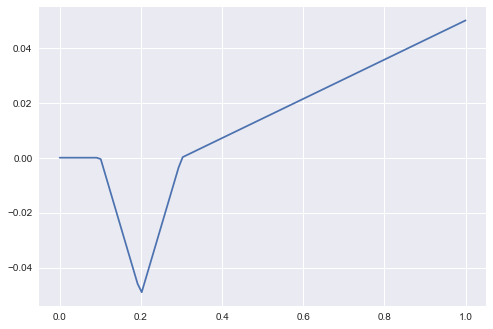

In [9]:
xcal = get_xcal(.2, .2, -.05, .05)
xs = np.linspace(0., 1., 100)
ys = xcal(xs)
print(xcal(0.5))
plt.plot(xs, ys)

In [312]:
class SemanticGraph(object):
    def __init__(self, adj=None, labels=None, word_dsm=None, 
                 xcal_dip_center=.2, xcal_dip_width=.2, xcal_min_adjust=-.05, xcal_max_adjust=.05):
        if word_dsm is None:
            self.adj = adj
        else:
            assert word_dsm.shape[0] == word_dsm.shape[1]
            word_adj = 1 - word_dsm
            np.fill_diagonal(word_adj, 0)
            self.adj = word_adj
        self.labels = labels
        self.xcal = get_xcal(xcal_dip_center, xcal_dip_width, xcal_min_adjust, xcal_max_adjust)
        self.lower_threshold = xcal_dip_center - (xcal_dip_width / 2)
     
    def activate(self, word_from, strength=1.0, decay=.8, new_adj=None, debug=False):
        """Spread activation through the network, adjusting synaptic weights."""
        if debug:
            print("{0} at strength {1}".format(word_from, strength))

        if new_adj is None:
            new_adj = copy.copy(self.adj)
        else:
            new_adj = copy.copy(new_adj)
        
        word_from_i = self.labels.index(word_from)
        next_layer_activations = new_adj[word_from_i] * strength * decay
        if debug:
            print(next_layer_activations.round(2))
        
        # Prevent loops by zeroing out weights back to already-activated nodes
        new_adj[:, word_from_i] = 0

        for word_to_i, activation in enumerate(next_layer_activations):
            if activation > self.lower_threshold:

                # Update edge weights
                word_to = self.labels[word_to_i]
                change = self.xcal(activation)
                if debug:
                    print("Updating edge: {0} -> {1}, + {2}".format(word_from, word_to, change))
                self.adj[word_from_i, word_to_i] += change
                if self.adj[word_from_i, word_to_i] > 1:
                    self.adj[word_from_i, word_to_i] = 1
                if self.adj[word_from_i, word_to_i] < 0:
                    self.adj[word_from_i, word_to_i] = 0
                self.activate(self.labels[word_to_i], strength=activation, new_adj=new_adj, debug=debug)

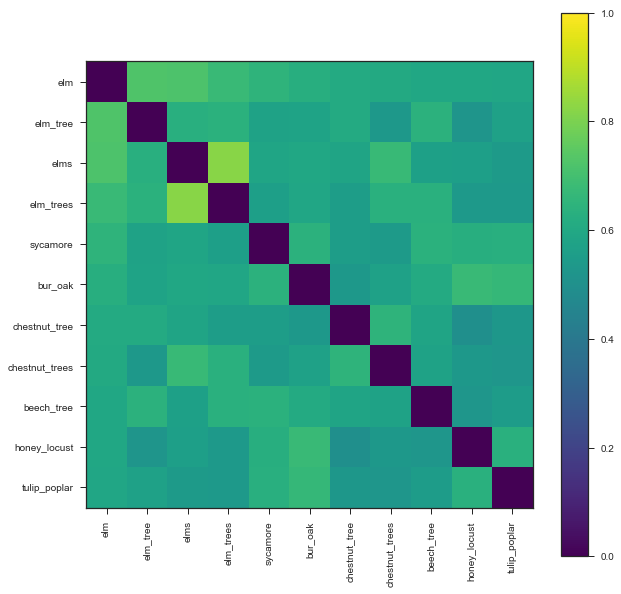

In [11]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

## Spreading activation and weight updating

### Activating one word over and over again

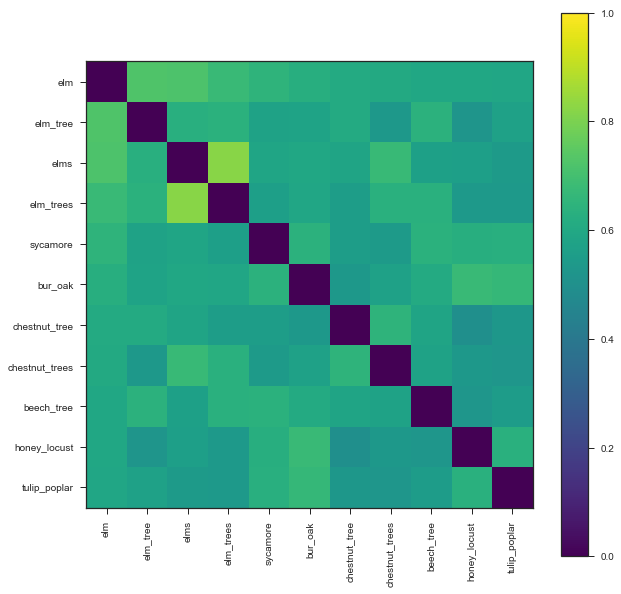

In [12]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [13]:
for i in range(20):
    g.activate('elm')

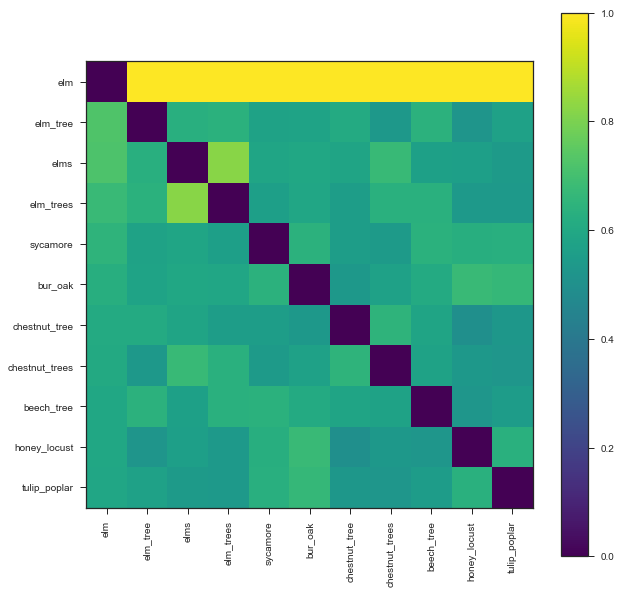

In [14]:
plot_labeled_matrix(g.adj, g.labels)

### Activating random words

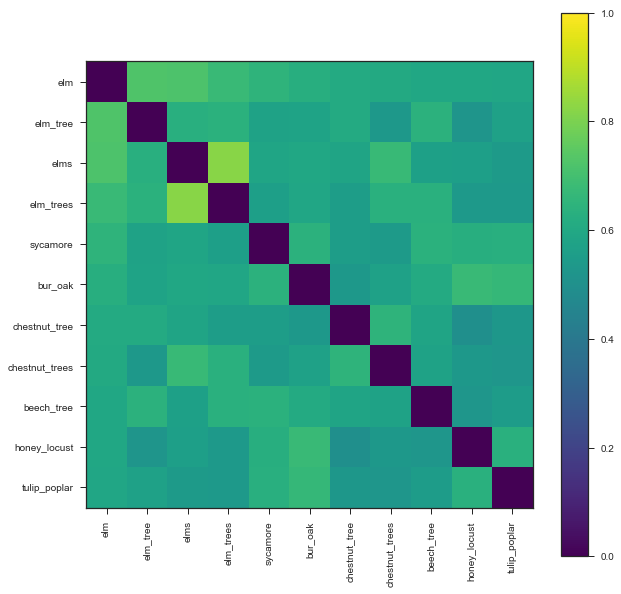

In [15]:
words_elm = connected_word_list('elm', google_news, n_iterations=1)
d = dist.squareform(semantic_dsm(word_list=words_elm, keyed_vectors=google_news))
g = SemanticGraph(word_dsm=d, labels=words_elm)
plot_labeled_matrix(g.adj, g.labels)

In [16]:
for i in range(200):
    g.activate(np.random.choice(g.labels, 1)[0])

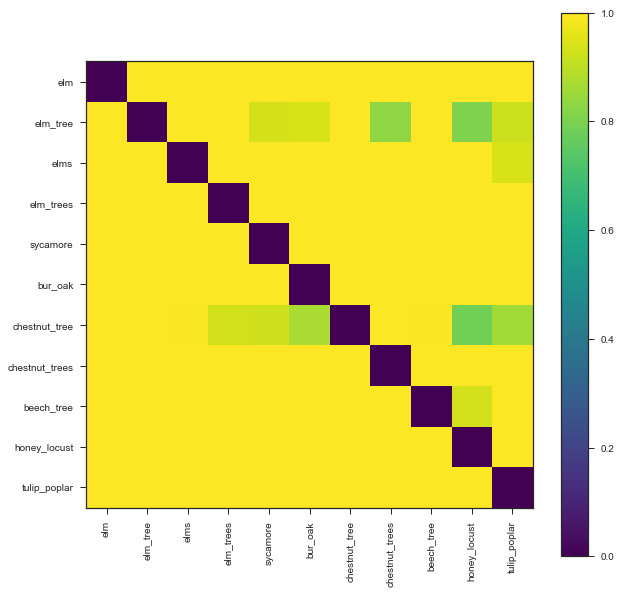

In [17]:
plot_labeled_matrix(g.adj, g.labels)

## Simulating previous work

### Goodmon & Anderson (2011), experiment 1

In [313]:
goodmon_pairs = {
    'animal': [
        ('lion', 'tiger'), 
        ('horse', 'pony'), 
        ('walrus', 'seal'), 
        ('duck', 'goose')
    ],
    
    'profession': [
        ('lawyer', 'judge'),
        ('chef', 'baker'),
        ('nurse', 'doctor'),
        ('president', 'senator')
    ],
    
    'appliance':[
        ('toaster', 'oven'),
        ('blender', 'mixer'),
        ('radio', 'stereo'),
        ('washer', 'dryer')
    ],
    
    'weapon': [
        ('gun', 'rifle'),
        ('bow', 'arrow'),
        ('poison', 'chemical'),
        ('dagger', 'sword')
    ],

    'city': [
        ('Reno', 'Memphis'),
        ('Detroit', 'London'),
        ('Paris', 'Atlanta'),
        ('Berlin', 'Orlando')
    ],

    'river': [
        ('Congo', 'Thames'),
        ('Amazon', 'Potomac'),
        ('Hudson', 'Rhine'),
        ('Suwanee', 'Nile')
    ]
}

In [314]:
class ExpGoodmonAnderson(object):
    def __init__(self, pairs_dict, keyed_vectors, study_strength, 
                 xcal_dip_center, xcal_dip_width, xcal_min_adjust, xcal_max_adjust,
                 no_practice_categories, filler_categories,
                 set_type, item_set):
        
        self.pairs_dict = pairs_dict
        self.keyed_vectors = keyed_vectors
        self.study_strength = study_strength
        self.no_practice_categories = no_practice_categories
        self.filler_categories = filler_categories
        self.xcal_dip_center = xcal_dip_center
        self.xcal_dip_width = xcal_dip_width
        self.xcal_min_adjust = xcal_min_adjust
        self.xcal_max_adjust = xcal_max_adjust
        assert set_type in ['inter', 'intra']
        self.set_type = set_type
        assert item_set in [0, 1]
        self.item_set = item_set
        self.ran = False
        
        self.all_words = []
        for category, pairs in self.pairs_dict.items():
            for pair in pairs:
                self.all_words.append(pair[0])
                self.all_words.append(pair[1])
        for category in self.pairs_dict.keys():
            self.all_words.append(category)
            
        dsm = dist.squareform(semantic_dsm(word_list=self.all_words, keyed_vectors=self.keyed_vectors))
        self.graph = SemanticGraph(
            word_dsm=dsm, 
            labels=self.all_words,
            xcal_dip_center=xcal_dip_center,
            xcal_dip_width=xcal_dip_width,
            xcal_min_adjust=xcal_min_adjust,
            xcal_max_adjust=xcal_max_adjust
        )
    
    def study_phase(self, debug=False):
        if debug:
            print("Beginning study phase.")
            
        study_pairs = []
        for category, pairs in self.pairs_dict.items():
            for pair in pairs:
                study_pairs.append((category, pair[0]))
                study_pairs.append((category, pair[1]))
        
        random.shuffle(study_pairs)
        
        for study_pair in study_pairs:
            self.study(study_pair[0], study_pair[1], debug=debug)
        
    def study(self, category, exemplar, debug=False):
        if debug:
            print("Study: {0} {1}".format(category, exemplar))
        
        # Strengthen the weights to and from the exemplar word and the category word
        category_i = self.graph.labels.index(category)
        exemplar_i = self.graph.labels.index(exemplar)
        #self.graph.adj[category_i, exemplar_i] += self.study_strength
        #self.graph.adj[exemplar_i, category_i] += self.study_strength
        
        self.graph.adj[category_i, exemplar_i] = self.xcal_dip_center + (self.xcal_dip_width / 2) + .15
        self.graph.adj[exemplar_i, category_i] = self.xcal_dip_center + (self.xcal_dip_width / 2) + .15
        
        self.graph.adj = np.clip(self.graph.adj, a_min=0, a_max=1)

        # Activate both nodes
        #self.graph.activate(category, debug=debug)
        #self.graph.activate(exemplar, debug=debug)
        
    def get_inter_set_pairs(self, item_set, debug=False):
        """Return a list of inter-set pairs.
        
        item_set: 0 for set A, 1 for set B
        omits no-practice categories
        """
        inter_set_pairs = []
        for category, pairs in self.pairs_dict.items():
            if category not in self.no_practice_categories:
                for pair in pairs:
                    inter_set_pairs.append((category, pair[item_set]))
        return inter_set_pairs
    
    def get_intra_set_pairs(self, item_set, debug=False):
        """Return a list of inter-set pairs.
        
        item_set: 0 for set A, 1 for set B
        omits no-practice categories
        """
        intra_set_pairs = []
        for category, pairs in self.pairs_dict.items():
            if category not in self.no_practice_categories:
                for pair_i, pair in enumerate(pairs):
                    if item_set == 0 and pair_i in [0, 3]:
                        intra_set_pairs.append((category, pair[0]))
                        intra_set_pairs.append((category, pair[1]))
                    elif item_set == 1 and pair_i in [1, 2]:
                        intra_set_pairs.append((category, pair[0]))
                        intra_set_pairs.append((category, pair[1]))
        return intra_set_pairs
        
    def recall_phase(self, practice_pairs, debug=False):
        for category, exemplar in practice_pairs:
            self.cued_recall(category, exemplar)
            #self.recall(exemplar)
            
    def recall(self, word, debug=False):
        self.graph.activate(word, debug=debug)
            
    def cued_recall(self, cue, correct, debug=False):
        #cue_i = self.graph.labels.index(cue)
        #correct_i = self.graph.labels.index(correct)
        #weight = self.graph.adj[cue_i, correct_i]
        
        # Think about this bit
        #success = np.random.uniform() < weight

        self.graph.activate(cue, debug=debug)
        self.graph.activate(correct, debug=debug)
        
        #if success:
        #    self.graph.activate(correct, debug=debug)

        #if debug:
        #    print("Cued recall. Cue: {0}  Correct: {1}  Weight: {2}  Success: {3}".format(
        #        cue, correct, weight, success
        #    ))
        #return success
    
    def analyze(self):
        rp_plus_item_set = self.item_set
        rp_minus_item_set = 0
        if self.item_set == 0:
            rp_minus_item_set = 1
        
        rp_plus = self.get_inter_set_pairs(item_set=rp_plus_item_set)
        rp_plus = [pair for pair in rp_plus if pair[0] not in self.filler_categories]
        rp_plus_i = [self.graph.labels.index(ex) for cat, ex in rp_plus]
        rp_plus_weights = [np.mean(self.graph.adj[:, i]) for i in rp_plus_i]

        rp_minus = self.get_inter_set_pairs(item_set=rp_minus_item_set)
        rp_minus = [pair for pair in rp_minus if pair[0] not in self.filler_categories]
        rp_minus_i = [self.graph.labels.index(ex) for cat, ex in rp_minus]
        rp_minus_weights = [np.mean(self.graph.adj[:, i]) for i in rp_minus_i]

        nrp = []
        for category, pairs in self.pairs_dict.items():
            if category in self.no_practice_categories:
                for pair in pairs:
                    nrp.append((category, pair[0]))
                    nrp.append((category, pair[1]))
        nrp_i = [self.graph.labels.index(ex) for cat, ex in nrp]
        nrp_weights = [np.mean(self.graph.adj[:, i]) for i in nrp_i]
        
        return [rp_plus_weights, rp_minus_weights, nrp_weights]
    
    def plot_analysis(self):
        weights = self.analyze() 
        ax_box = sns.boxplot(data=weights)
        ax_swarm = sns.swarmplot(data=weights, color='black')
        ax_swarm.set(xticklabels=['rp+', 'rp-', 'nrp'])
        
    def run(self):
        print("Running")
            
        self.study_phase()
        for _ in range(10):
            if self.set_type == 'inter':
                self.recall_phase(self.get_inter_set_pairs(self.item_set))
            elif self.set_type == 'intra':
                self.recall_phase(self.get_intra_set_pairs(self.item_set))
        self.ran = True

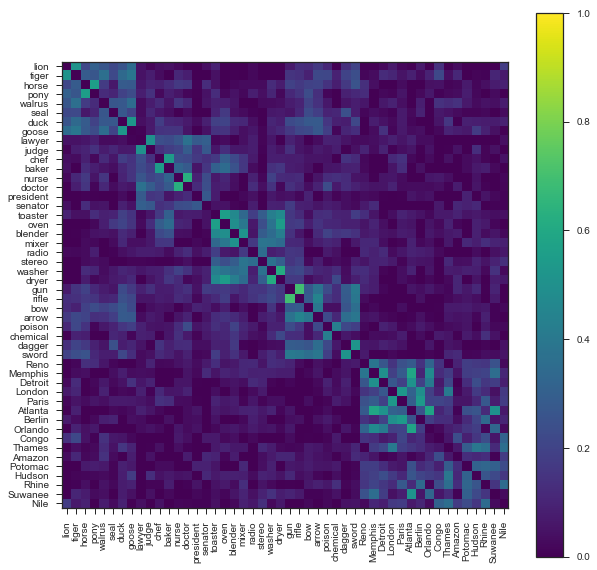

Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running


In [265]:
rp_plus_inter = []
rp_minus_inter = []
nrp_inter = []

rp_plus_intra = []
rp_minus_intra = []
nrp_intra = []

study_strength=.2
xcal_dip_center=.2
xcal_dip_width=.15
xcal_min_adjust=-.05
xcal_max_adjust=.15

temp = ExpGoodmonAnderson(
    pairs_dict=goodmon_pairs,
    keyed_vectors=google_news,
    study_strength=study_strength,
    xcal_dip_center=xcal_dip_center, 
    xcal_dip_width=xcal_dip_width, 
    xcal_min_adjust=xcal_min_adjust, 
    xcal_max_adjust=xcal_max_adjust,
    no_practice_categories=[nrp_cat],
    filler_categories=['city', 'river'],
    set_type = 'inter',
    item_set = 0
)
plot_labeled_matrix(temp.graph.adj, temp.graph.labels)
plt.show()

for nrp_cat in ['animal', 'profession', 'appliance', 'weapon']:    
    e_inter_0 = ExpGoodmonAnderson(
        pairs_dict=goodmon_pairs,
        keyed_vectors=google_news,
        study_strength=study_strength,
        xcal_dip_center=xcal_dip_center, 
        xcal_dip_width=xcal_dip_width, 
        xcal_min_adjust=xcal_min_adjust, 
        xcal_max_adjust=xcal_max_adjust,
        no_practice_categories=[nrp_cat],
        filler_categories=['city', 'river'],
        set_type = 'inter',
        item_set = 0
    )
    e_inter_1 = ExpGoodmonAnderson(
        pairs_dict=goodmon_pairs,
        keyed_vectors=google_news,
        study_strength=study_strength,
        xcal_dip_center=xcal_dip_center, 
        xcal_dip_width=xcal_dip_width, 
        xcal_min_adjust=xcal_min_adjust, 
        xcal_max_adjust=xcal_max_adjust,
        no_practice_categories=[nrp_cat],
        filler_categories=['city', 'river'],
        set_type = 'inter',
        item_set = 1
    )
    e_intra_0 = ExpGoodmonAnderson(
        pairs_dict=goodmon_pairs,
        keyed_vectors=google_news,
        study_strength=study_strength,
        xcal_dip_center=xcal_dip_center, 
        xcal_dip_width=xcal_dip_width, 
        xcal_min_adjust=xcal_min_adjust, 
        xcal_max_adjust=xcal_max_adjust,
        no_practice_categories=[nrp_cat],
        filler_categories=['city', 'river'],
        set_type = 'intra',
        item_set = 0
    )
    e_intra_1 = ExpGoodmonAnderson(
        pairs_dict=goodmon_pairs,
        keyed_vectors=google_news,
        study_strength=study_strength,
        xcal_dip_center=xcal_dip_center, 
        xcal_dip_width=xcal_dip_width, 
        xcal_min_adjust=xcal_min_adjust, 
        xcal_max_adjust=xcal_max_adjust,
        no_practice_categories=[nrp_cat],
        filler_categories=['city', 'river'],
        set_type = 'intra',
        item_set = 1
    )
    
    for exp in [e_inter_0, e_inter_1]:
        exp.run()
        a, b, c = exp.analyze()
        rp_plus_inter += list(a)
        rp_minus_inter += list(b)
        nrp_inter += list(c)
        
    for exp in [e_intra_0, e_intra_1]:
        exp.run()
        a, b, c = exp.analyze()
        rp_plus_intra += list(a)
        rp_minus_intra += list(b)
        nrp_intra += list(c)

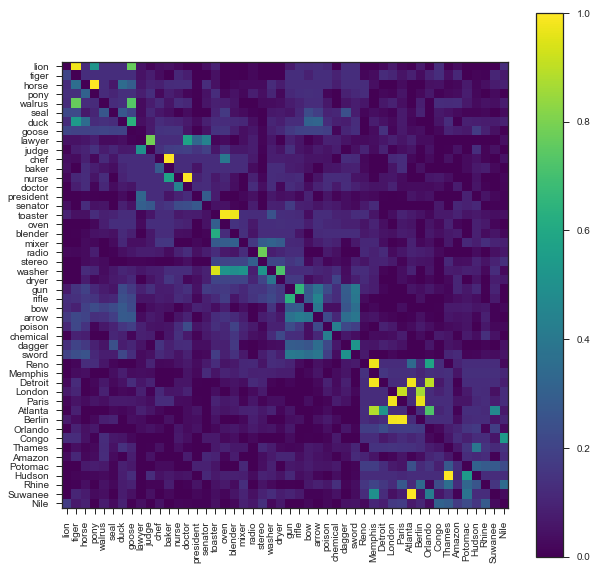

In [266]:
#for i in range(1):
#    e_inter_0.recall('lion', debug=False)
plot_labeled_matrix(e_inter_0.graph.adj, e_inter_0.graph.labels)

0.0868304949403
0.092956587252
0.0933462670086


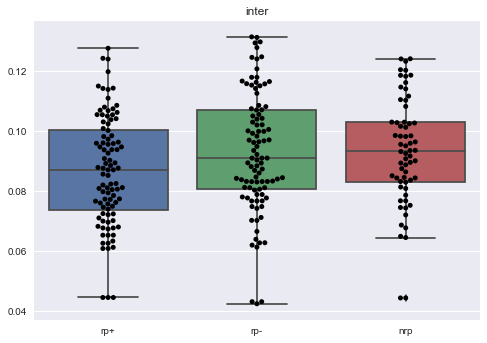

In [262]:
print(np.mean(rp_plus_inter))
print(np.mean(rp_minus_inter))
print(np.mean(nrp_inter))

weights = [rp_plus_inter, rp_minus_inter, nrp_inter]

ax_box = sns.boxplot(data=weights);
ax_swarm = sns.swarmplot(data=weights, color='black');
ax_swarm.set(xticklabels=['rp+', 'rp-', 'nrp']);
plt.title("inter");

0.0908559419841
0.0929928817005
0.0947697464521


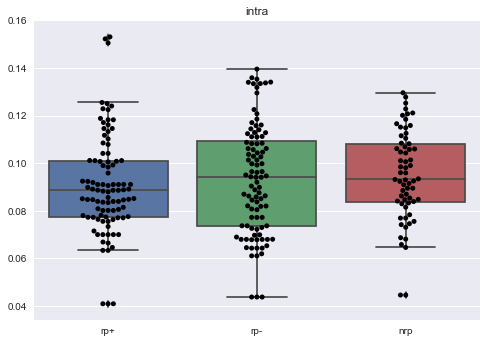

In [263]:
print(np.mean(rp_plus_intra))
print(np.mean(rp_minus_intra))
print(np.mean(nrp_intra))

weights = [rp_plus_intra, rp_minus_intra, nrp_intra]

ax_box = sns.boxplot(data=weights);
ax_swarm = sns.swarmplot(data=weights, color='black');
ax_swarm.set(xticklabels=['rp+', 'rp-', 'nrp']);
plt.title("intra");

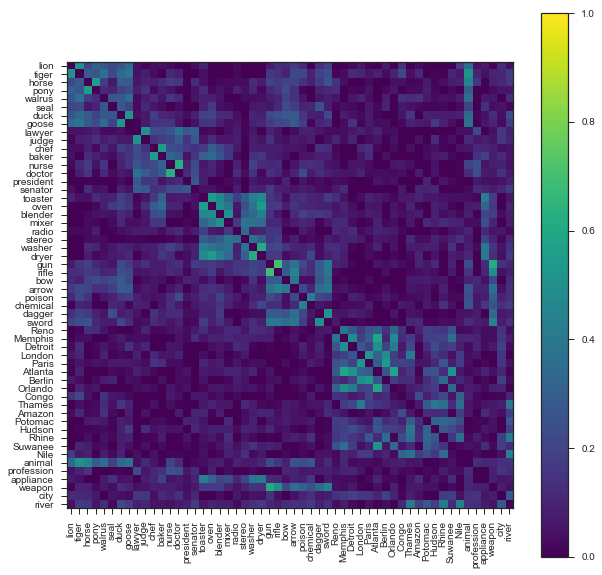

In [315]:
temp = ExpGoodmonAnderson(
    pairs_dict=goodmon_pairs,
    keyed_vectors=google_news,
    study_strength=study_strength,
    xcal_dip_center=xcal_dip_center, 
    xcal_dip_width=xcal_dip_width, 
    xcal_min_adjust=xcal_min_adjust, 
    xcal_max_adjust=xcal_max_adjust,
    no_practice_categories=[nrp_cat],
    filler_categories=['city', 'river'],
    set_type = 'inter',
    item_set = 0
)
plot_labeled_matrix(temp.graph.adj, temp.graph.labels)
plt.show()

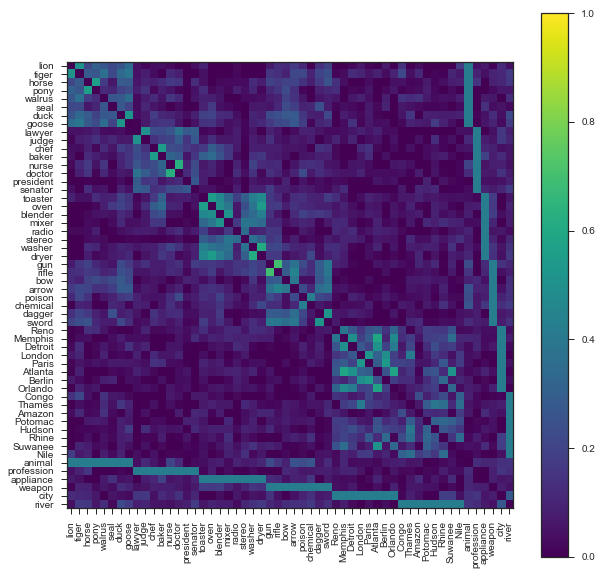

In [316]:
temp.study_phase()
plot_labeled_matrix(temp.graph.adj, temp.graph.labels)

Running


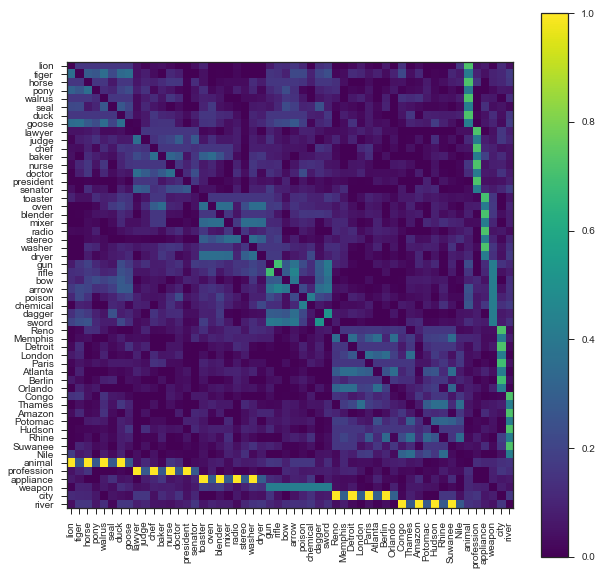

In [317]:
temp.run()
plot_labeled_matrix(temp.graph.adj, temp.graph.labels)

#### Study phase

<blockquote>In the study phase, participants saw category—exemplars pairs in the center of the computer screen at a rate of 5s each, and they were told to study each pair by relating the exemplar to its category name. The order for the pairs was block randomized, so that each block contained one exemplar from each category. The resulting eight blocks of six items (four items from the experimental categories and two items from the filler categories) ensured that exemplars from the categories were evenly distributed throughout the list. Within each block, the order was random except that (a) in the first block, filler items were presented first to minimize primacy effects; (b) in the last block, two fillers were presented last to minimize recency effects; (c) no two categories appeared in sequence more than once; and (d) exemplars within the same category were spaced so that there was an average of seven other items in between them. Also, the average distance between the Rp+ and the Rp- items for a given category was kept constant across the inter-set and intra-set conditions, and Rp+ and Rp- items within each category were distributed throughout the study list.</blockquote>

We are not going to do the fancy recency counterbalancing.

#### Recall phase

<blockquote>In the retrieval practice phase, participants were told that their memory would be tested. They were told that on each test trial, they would see a category name and the first two letters of one member from that category on the screen, and they were asked to recall the studied category member that fit the letters and say the category and member out loud within 10 s. They were told that some of the words would be tested more than once and that they should recall them as they would any other. The presentation order of the category-plus-two-letter stem cues was pseudorandomized with the following constraints: (a) The first three and last three cues were filler items to acquaint participants with the task and to control for primacy and recency effects; (b) items were tested three times on an expanding schedule with an average of 3.5 trials between the first and second presentations and an average of 6.5 trials between the second and third presentations; (c) no two category members were retrieval practiced in succession; and (d) the use of filler items helped ensure that no two pairs appeared consecutively more than once.</blockquote>

Not doing the fancy counterbalancing/spacing.

There are two conditions: inter-set and intra-set. In the inter-set condition, one pair member is practiced and the other is not. In the intra-set condition, both members of two pairs are practiced, and the other two pairs are not praticed.

## Getting reasonable word lists and distance matrices from the Google News corpus

### n clusters of hierarchically related words based on category seeds

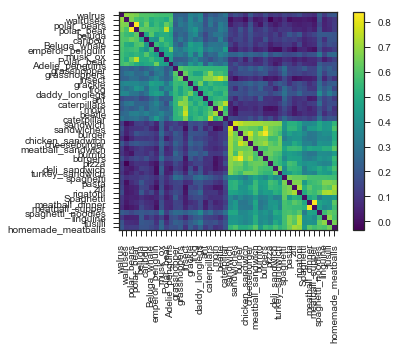

In [130]:
seeds = ['walrus', 'grasshopper', 'sandwich', 'spaghetti']
animals_food = []
for seed in seeds:
    animals_food += connected_word_list(seed, google_news, n_iterations=1)

animals_food_dsm = dist.squareform(semantic_dsm(word_list=animals_food, keyed_vectors=google_news))

animals_food_graph = SemanticGraph(word_dsm=animals_food_dsm, labels=animals_food)
plot_labeled_matrix(animals_food_graph.adj, animals_food_graph.labels)

### Randomly sample from the vocabulary

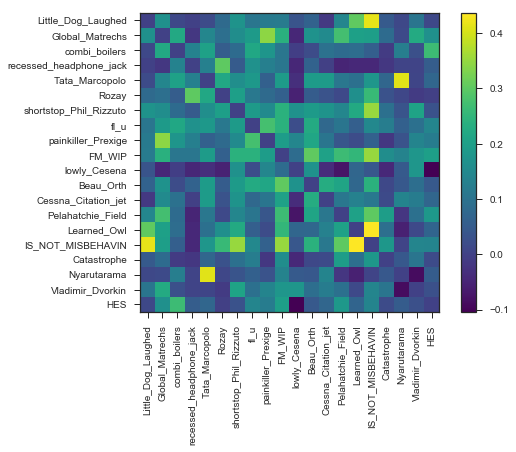

In [11]:
random_words = np.random.choice(list(google_news.vocab.keys()), 20)
random_words_dsm = dist.squareform(semantic_dsm(word_list=random_words, keyed_vectors=google_news))
random_words_graph = SemanticGraph(word_dsm=random_words_dsm, labels=random_words)

plot_labeled_matrix(random_words_graph.adj, random_words_graph.labels)

### Get vocabulary from a seed document

In [14]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

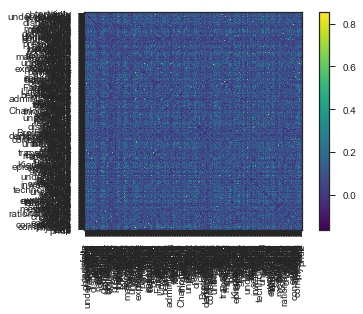

In [58]:
with open('../data/brooks.txt', 'r') as f:
    lines = f.readlines()
    
lines = [line.strip() for line in lines]
lines_string = ' '.join(lines)

# Strip punctuation
punctuation = string.punctuation + '“”—’'
punctuation = punctuation.replace('-', '')
remove_punct_map = dict.fromkeys(map(ord, punctuation))
lines_string = lines_string.translate(remove_punct_map)

# Remove stopwords
words = set(word_tokenize(lines_string))
stop_words = set(stopwords.words('english'))
words = [word for word in words if word not in stop_words]

# Build a keyed vector dictionary, omitting words that are not in the corpus
brooks_dsm, brooks_labels = semantic_dsm_safe(words, google_news)
brooks_graph = SemanticGraph(word_dsm=dist.squareform(brooks_dsm), labels=brooks_labels)
plot_labeled_matrix(brooks_graph.adj, brooks_graph.labels)

In [59]:
words

['certainty',
 'falls',
 'objectively',
 'nation',
 'blind',
 'understanding',
 'courage',
 'everything',
 'provides',
 'conflict',
 'political',
 'may',
 'fired',
 'live',
 'living',
 'dishonesty',
 'much',
 'original',
 'defined',
 'escape',
 'opposed',
 'In',
 'evidence',
 'mongering',
 'Bannon',
 'assertive',
 'questions',
 'big',
 'pain',
 'moment',
 'seems',
 'depressing',
 'rest',
 'Muslim',
 'competing',
 'anger',
 'security',
 'unnamable',
 'boundaries',
 'whites',
 'Higgins',
 'adjustment',
 'tough',
 'due',
 'deal',
 'Donald',
 'trust',
 'build',
 'presidency',
 'Progress',
 'whole',
 'war',
 'Many',
 'diversity',
 'anything',
 'incuriosity',
 'possess',
 'foreigners',
 'stand',
 'Americas',
 'leads',
 'Were',
 'system',
 'Over',
 'going',
 'fanaticism',
 'next',
 'appreciate',
 'malevolently',
 'within',
 'loons',
 'written',
 'controlled',
 'vicious',
 'learning',
 'Back',
 'crushing',
 'understood',
 'creativity',
 'anxiety',
 'inevitably',
 'But',
 'take',
 'give',
 'nec

## Spectral clustering (or at least re-ordering)

(This maybe doesn't work right now?)

In [236]:
def discretize(similarity_matrix, threshold=.5):
    zeros = np.zeros_like(similarity_matrix)
    zeros[similarity_matrix > threshold] = 1
    return zeros

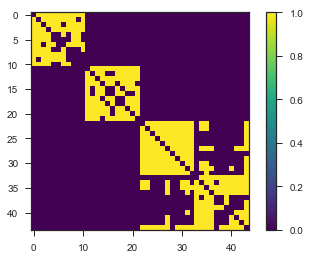

In [237]:
plot_labeled_matrix(discretize(animals_food_graph.adj))

In [238]:
def degree_continuous(similarity_matrix, edge_type='in', discrete=False):
    assert edge_type in ['in', 'out']
    if edge_type is 'in':
        axis = 0
    if edge_type is 'out':
        axis = 1
    if discrete:
        similarity_matrix = discretize(similarity_matrix)
    diag = np.sum(similarity_matrix, axis=0)
    degree = np.zeros_like(similarity_matrix)
    np.fill_diagonal(degree, diag)
    return degree

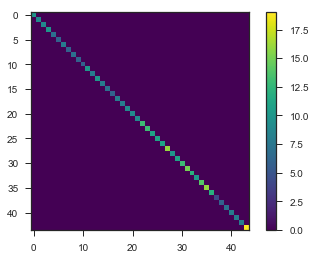

In [239]:
plot_labeled_matrix(degree_continuous(animals_food_graph.adj, discrete=True))

In [240]:
D = degree_continuous(animals_food_graph.adj, discrete=True)
W = animals_food_graph.adj
L = D - W

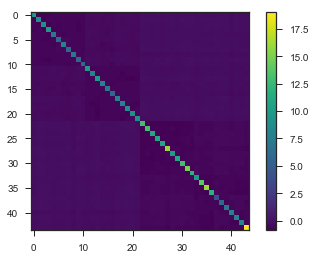

In [241]:
plot_labeled_matrix(L)

In [242]:
eigenvalues, eigenvectors = np.linalg.eig(L)

In [244]:
# Get the eigenvector associated with the 2nd smallest eigenvalue
index_of_second_smallest_evalue = sorted(enumerate(eigenvalues), key=lambda i:i[1])[1][0]
second_smallest_evector = eigenvectors[index_of_second_smallest_evalue]

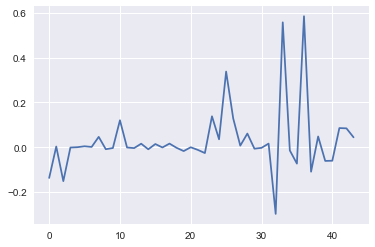

In [245]:
plt.plot(second_smallest_evector)

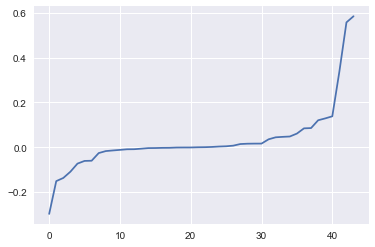

In [246]:
plt.plot(sorted(second_smallest_evector))

In [247]:
cluster_order = np.array(sorted(enumerate(second_smallest_evector), key=lambda i:i[1]), dtype=np.int)[:, 0]

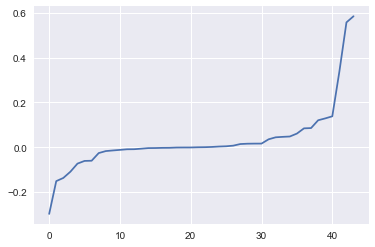

In [248]:
plt.plot(second_smallest_evector[cluster_order])

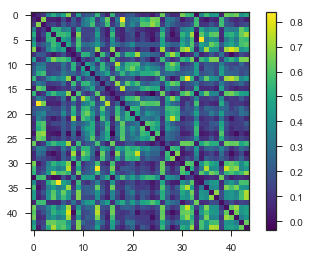

In [249]:
r = animals_food_graph.adj[cluster_order,:]
r = r[:,cluster_order]
plot_labeled_matrix(r)

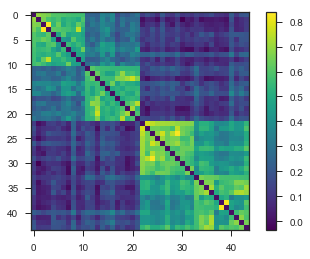

In [232]:
plot_labeled_matrix(animals_food_graph.adj)

In [224]:
from scipy.io import savemat

In [225]:
savemat('animals_food.mat', {'adj': animals_food_graph.adj, 'labels': animals_food_graph.labels})

## Saving and loading word vectors

In [3]:
import json

In [362]:
kv = {word: google_news.word_vec(word).tolist() for word in animals_food}

In [363]:
with open('animals_food.json', 'w') as f:
    json.dump(kv, f)

In [6]:
with open('../data/animals_food.json', 'r') as f:
    kv_loaded = json.load(f)

In [7]:
kv_loaded['animal']

KeyError: 'animal'